# 1.0 Analyzing green space

In [4]:
# Metric: Trees per square mile by neighborhood

import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

## 1.1 Load datasets

In [6]:
# set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

print("\n1. Loading datasets...")

trees_df = pd.read_csv("../data/trees.csv")
print(f"loaded {len(trees_df):,} tree records")

neighborhoods_df = pd.read_csv("../data/neighborhoods.csv")
print(f"loaded {len(neighborhoods_df):,} neighborhoods")


1. Loading datasets...
loaded 45,709 tree records
loaded 90 neighborhoods


## 1.2 Explore the data

In [10]:
print("\n2. Exploring data structure...")
print("\nTree dataset columns:")
print(trees_df.columns.tolist())

print("\nNeighborhood dataset columns:")
print(neighborhoods_df.columns.tolist())

print("\nSample tree records:")
print(trees_df[['common_name', 'neighborhood', 'height', 'condition']].head())

print("\nTree condition distribution:")
print(trees_df['condition'].value_counts())


2. Exploring data structure...

Tree dataset columns:
['_id', 'id', 'address_number', 'street', 'common_name', 'scientific_name', 'height', 'width', 'growth_space_length', 'growth_space_width', 'growth_space_type', 'diameter_base_height', 'stems', 'overhead_utilities', 'land_use', 'condition', 'stormwater_benefits_dollar_value', 'stormwater_benefits_runoff_elim', 'property_value_benefits_dollarvalue', 'property_value_benefits_leaf_surface_area', 'energy_benefits_electricity_dollar_value', 'energy_benefits_gas_dollar_value', 'air_quality_benfits_o3dep_dollar_value', 'air_quality_benfits_o3dep_lbs', 'air_quality_benfits_vocavd_dollar_value', 'air_quality_benfits_vocavd_lbs', 'air_quality_benfits_no2dep_dollar_value', 'air_quality_benfits_no2dep_lbs', 'air_quality_benfits_no2avd_dollar_value', 'air_quality_benfits_no2avd_lbs', 'air_quality_benfits_so2dep_dollar_value', 'air_quality_benfits_so2dep_lbs', 'air_quality_benfits_so2avd_dollar_value', 'air_quality_benfits_so2avd_lbs', 'air_qual

## 1.3 Clean the data

In [9]:
# clean data
print("\n3. Cleaning data...")

# rm trees with missing neighborhood
trees_df = trees_df.dropna(subset=["neighborhood"])
print(f"removed trees without neighborhood: {len(trees_df):,} trees remaining")

# standardize neighborhood names
trees_df['neighborhood'] = trees_df['neighborhood'].str.strip().str.title()
neighborhoods_df['hood'] = neighborhoods_df['hood'].str.strip().str.title()

# filter out stumps
trees_df = trees_df[trees_df['common_name'] != 'Stump']
print(f"removed stumps: {len(trees_df):,} living trees remaining")


3. Cleaning data...
removed trees without neighborhood: 45,450 trees remaining
removed stumps: 44,371 living trees remaining


## 1.4 Calculate green space metrics

In [15]:
print("n4. Calculating green space metrics...")

trees_per_neighborhood = trees_df.groupby('neighborhood').agg({
    'id': 'count',
    'overall_benefits_dollar_value': 'sum',
    'stormwater_benefits_dollar_value': 'sum',
    'co2_benefits_dollar_value': 'sum'
}).reset_index()

trees_per_neighborhood.columns = [
    'neighborhood',
    'tree_count',
    'total_benefits_dollars',
    'stormwater_benefits',
    'co2_benefits'
]

# merge with neighborhood data to get area
merged = neighborhoods_df[['hood', 'sqmiles', 'acres']].merge(
    trees_per_neighborhood,
    left_on='hood',
    right_on='neighborhood',
    how='left'
)

# fill neighborhoods with no trees as 0
merged['tree_count'] = merged['tree_count'].fillna(0)
merged['total_benefits_dollars'] = merged['total_benefits_dollars'].fillna(0)

# calculate trees per square mile
merged['trees_per_sq_mi'] = merged['tree_count'] / merged['sqmiles']

# calculate benefit value per acre
merged['benefits_per_acre'] = merged['total_benefits_dollars'] / merged['acres']
merged['benefits_per_acre'] = merged['benefits_per_acre'].fillna(0)

print("\ncalculated metrics:")
print(f" {merged['trees_per_sq_mi'].mean():.2f} - Trees per square mile")
print(f" ${merged['benefits_per_acre'].mean():.2f} - Environmental benefit value per acre")
print(f" ${merged['total_benefits_dollars'].sum():.2f} - Total ecosystem service value")

n4. Calculating green space metrics...

calculated metrics:
 863.51 - Trees per square mile
 $139.37 - Environmental benefit value per acre
 $4860345.19 - Total ecosystem service value


## 1.5 Normalize and evaluate neighborhoods by green space

### 1.5.1 Normalizing to green space score (0-100)

In [22]:
# we'll combine two metrics:
# - tree density (trees per sq mi)
# - environmental value (benefits per acre)

# normalize values to 0-100
max_density = merged['trees_per_sq_mi'].max()
merged['density_score'] = (merged['trees_per_sq_mi'] / max_density) * 100
max_benefits = merged['benefits_per_acre'].max()
merged['benefits_score'] = (merged['benefits_per_acre'] / max_benefits) * 100

# combined score (60% density, 40% environmental value)
merged['green_space_score'] = (
    merged['density_score'] * 0.6 + 
    merged['benefits_score'] * 0.4
)

merged['green_space_score'] = merged['green_space_score'].round(2)

### 1.5.1 Ranking neighborhoods

In [25]:
top_15 = merged.nlargest(15, 'green_space_score')[[
    'hood', 
    'tree_count', 
    'trees_per_sq_mi',
    'benefits_per_acre',
    'green_space_score'
]].round(2)

print("top 15 neighborhoods by green space:")
print(top_15.to_string(index=False))

top 15 neighborhoods by green space:
               hood  tree_count  trees_per_sq_mi  benefits_per_acre  green_space_score
   Allegheny Center         863          4130.44            1106.14             100.00
         Friendship         356          3352.44             377.40              62.35
     Allegheny West         384          2652.04             592.04              59.93
      Highland Park        2914          2490.90             544.03              55.86
      Regent Square         431          2196.53             470.38              48.92
  Central Northside         658          2533.91             323.64              48.51
         Manchester         695          2490.61             331.19              48.16
       East Liberty        1335          2296.26             275.67              43.32
   Crawford-Roberts         563          2239.98             265.89              42.15
Squirrel Hill South        5033          1880.37             408.20              42.08
Squirr

Saved: green_space_rankings.png


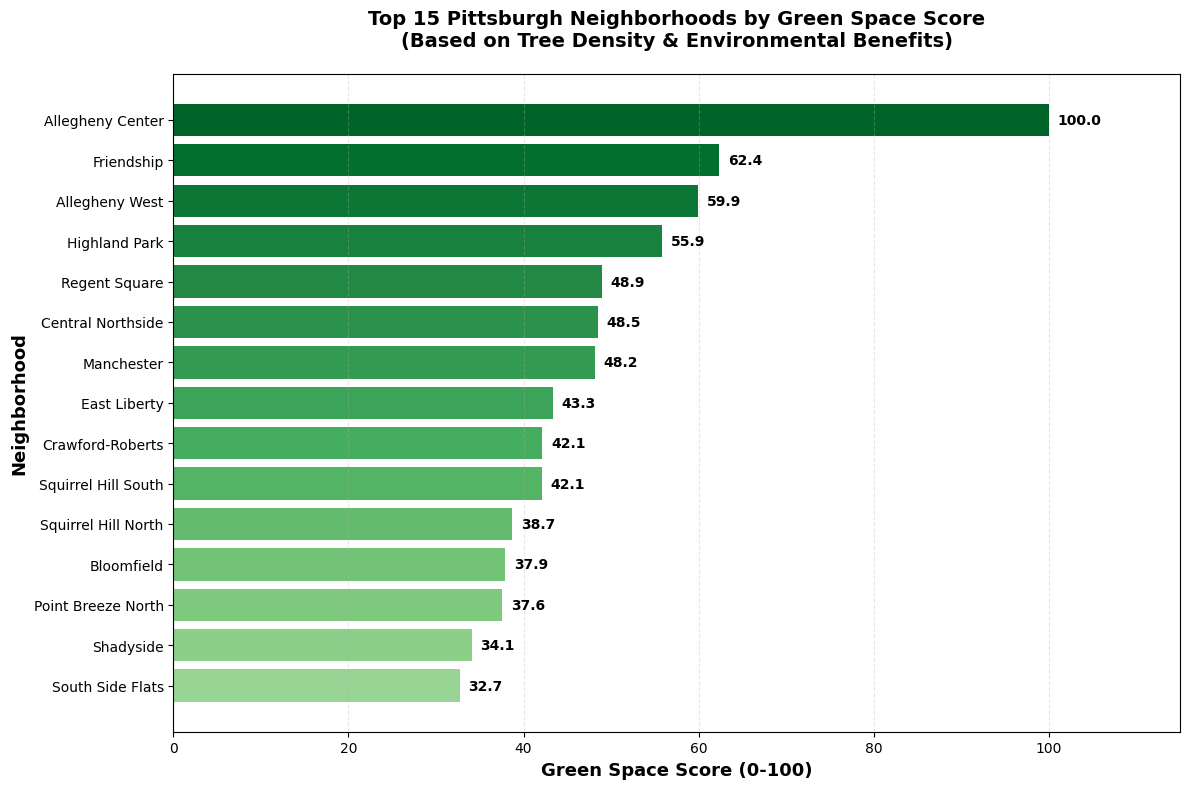

Saved: green_space_scatter.png


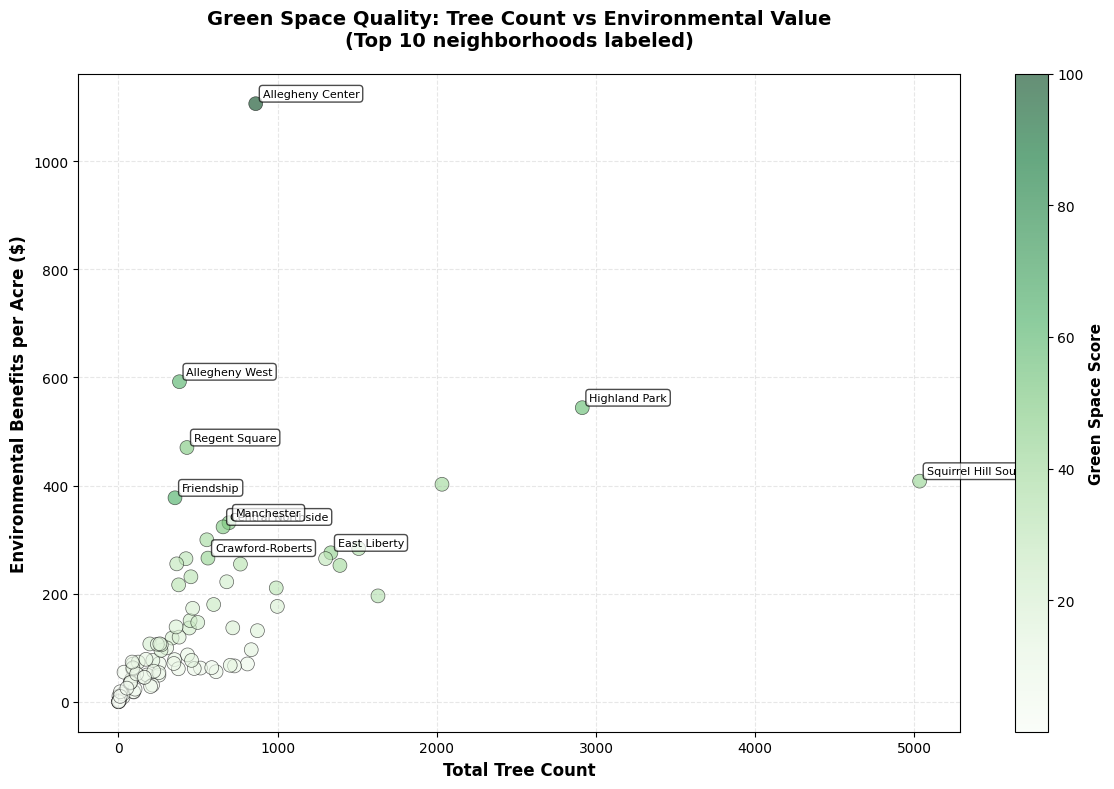

Saved: tree_distribution_all.png


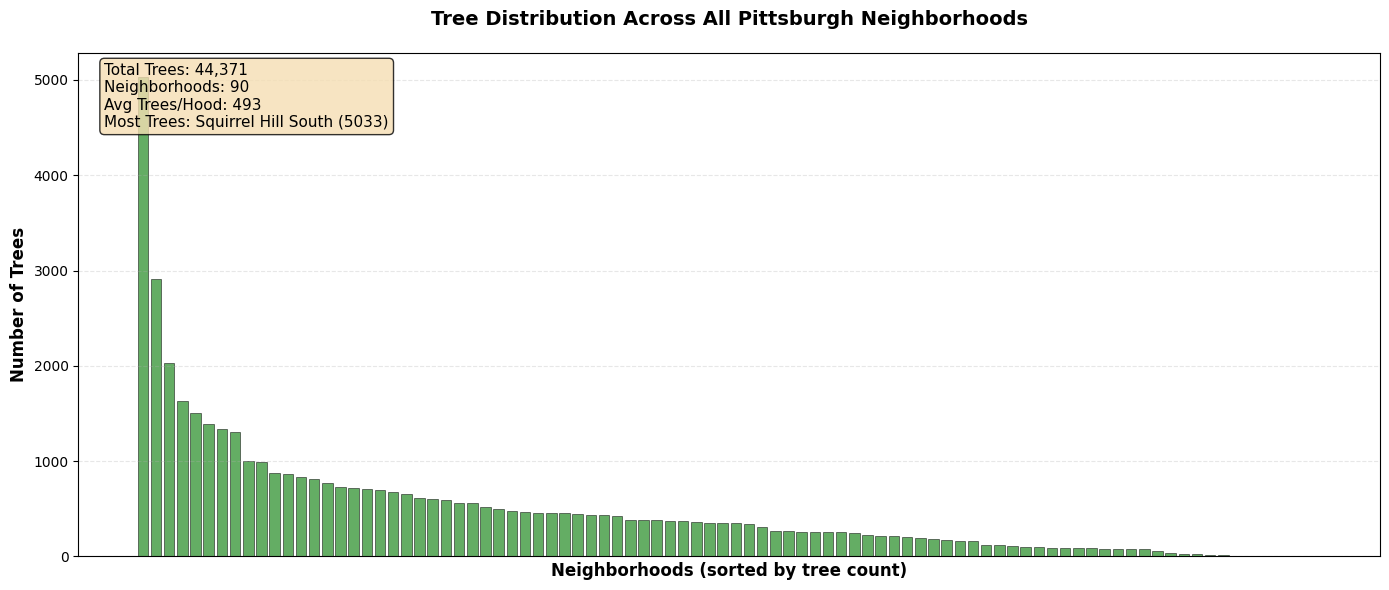

In [26]:
# visualize

# visual 1: horizontal bar chart of top 15
fig, ax = plt.subplots(figsize=(12, 8))
top_15_sorted = merged.nlargest(15, 'green_space_score').sort_values('green_space_score')

colors = plt.cm.Greens(np.linspace(0.4, 0.9, len(top_15_sorted)))
bars = ax.barh(top_15_sorted['hood'], top_15_sorted['green_space_score'], color=colors)

for i, (bar, value) in enumerate(zip(bars, top_15_sorted['green_space_score'])):
    ax.text(value + 1, i, f'{value:.1f}', 
            va='center', fontsize=10, fontweight='bold')

ax.set_xlabel('Green Space Score (0-100)', fontsize=13, fontweight='bold')
ax.set_ylabel('Neighborhood', fontsize=13, fontweight='bold')
ax.set_title('Top 15 Pittsburgh Neighborhoods by Green Space Score\n(Based on Tree Density & Environmental Benefits)', 
             fontsize=14, fontweight='bold', pad=20)
ax.set_xlim(0, max(top_15_sorted['green_space_score']) * 1.15)
ax.grid(axis='x', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.savefig('../docs/green_space_rankings.png', dpi=300, bbox_inches='tight')
print("Saved: green_space_rankings.png")
plt.show()

# visual 2: tree count vs benefits scatter
fig, ax = plt.subplots(figsize=(12, 8))

scatter = ax.scatter(merged['tree_count'], 
                     merged['benefits_per_acre'],
                     c=merged['green_space_score'],
                     cmap='Greens',
                     s=100,
                     alpha=0.6,
                     edgecolors='black',
                     linewidth=0.5)

top_10 = merged.nlargest(10, 'green_space_score')
for _, row in top_10.iterrows():
    ax.annotate(row['hood'], 
                (row['tree_count'], row['benefits_per_acre']),
                fontsize=8,
                xytext=(5, 5),
                textcoords='offset points',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7))

ax.set_xlabel('Total Tree Count', fontsize=12, fontweight='bold')
ax.set_ylabel('Environmental Benefits per Acre ($)', fontsize=12, fontweight='bold')
ax.set_title('Green Space Quality: Tree Count vs Environmental Value\n(Top 10 neighborhoods labeled)', 
             fontsize=14, fontweight='bold', pad=20)

cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Green Space Score', fontsize=11, fontweight='bold')

ax.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()
plt.savefig('../docs/green_space_scatter.png', dpi=300, bbox_inches='tight')
print("Saved: green_space_scatter.png")
plt.show()

# visual 3: distribution of trees across city
fig, ax = plt.subplots(figsize=(14, 6))

all_hoods = merged.sort_values('tree_count', ascending=False)

ax.bar(range(len(all_hoods)), all_hoods['tree_count'], 
       color='forestgreen', alpha=0.7, edgecolor='black', linewidth=0.5)

ax.set_xlabel('Neighborhoods (sorted by tree count)', fontsize=12, fontweight='bold')
ax.set_ylabel('Number of Trees', fontsize=12, fontweight='bold')
ax.set_title('Tree Distribution Across All Pittsburgh Neighborhoods', 
             fontsize=14, fontweight='bold', pad=20)
ax.set_xticks([])  # remove x-axis labels (too many neighborhoods)

textstr = f"Total Trees: {merged['tree_count'].sum():,.0f}\n"
textstr += f"Neighborhoods: {len(merged)}\n"
textstr += f"Avg Trees/Hood: {merged['tree_count'].mean():.0f}\n"
textstr += f"Most Trees: {all_hoods.iloc[0]['hood']} ({all_hoods.iloc[0]['tree_count']:.0f})"

props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
ax.text(0.02, 0.98, textstr, transform=ax.transAxes, fontsize=11,
        verticalalignment='top', bbox=props)

ax.grid(axis='y', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.savefig('../docs/tree_distribution_all.png', dpi=300, bbox_inches='tight')
print("Saved: tree_distribution_all.png")
plt.show()

In [27]:
# save results

output_df = merged[[
    'hood', 
    'tree_count', 
    'sqmiles',
    'trees_per_sq_mi',
    'total_benefits_dollars',
    'benefits_per_acre',
    'green_space_score'
]].sort_values('green_space_score', ascending=False)

output_df.to_csv('../data/green_space_scores.csv', index=False)
print("Saved: green_space_scores.csv")

Saved: green_space_scores.csv
